In [1]:
from model import GPT
import numpy as np
import torch
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
data = np.memmap('/data2/mengfanxu/nanoGPT/data/openwebtext/val.bin', dtype=np.uint16, mode='r')

In [3]:
batch_size = 16
block_size = 1024
ix = torch.randint(len(data) - block_size, (batch_size,))
x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])

In [4]:
model = GPT.from_pretrained('/data2/mengfanxu/huggingface/gpt2-xl')

/home/mengfanxu/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading weights from pretrained gpt: gpt2-xl
forcing vocab_size=50257, block_size=1024, bias=True
number of parameters: 1555.97M


In [10]:
layer=0
q_proj = deepcopy(model.transformer.h[layer].attn.q_proj)
k_proj = deepcopy(model.transformer.h[layer].attn.k_proj)
v_proj = deepcopy(model.transformer.h[layer].attn.v_proj)
o_proj = deepcopy(model.transformer.h[layer].attn.o_proj)
torch.save(q_proj, "state_dict/gpt2/vanilla_q_proj.pt")
torch.save(k_proj, "state_dict/gpt2/vanilla_k_proj.pt")
torch.save(v_proj, "state_dict/gpt2/vanilla_v_proj.pt")
torch.save(o_proj, "state_dict/gpt2/vanilla_o_proj.pt")

In [12]:
orthogonal_model = deepcopy(model)
state_dict = torch.load("orthogonal/gpt2-xl.pt")
orthogonal_model.load_state_dict(state_dict)
q_proj = deepcopy(orthogonal_model.transformer.h[layer].attn.q_proj)
k_proj = deepcopy(orthogonal_model.transformer.h[layer].attn.k_proj)
v_proj = deepcopy(orthogonal_model.transformer.h[layer].attn.v_proj)
o_proj = deepcopy(orthogonal_model.transformer.h[layer].attn.o_proj)
torch.save(q_proj, "state_dict/gpt2/orthogonal_q_proj.pt")
torch.save(k_proj, "state_dict/gpt2/orthogonal_k_proj.pt")
torch.save(v_proj, "state_dict/gpt2/orthogonal_v_proj.pt")
torch.save(o_proj, "state_dict/gpt2/orthogonal_o_proj.pt")

/tmp/ipykernel_3059871/608098321.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("orthogonal/gpt2-xl.pt")


In [6]:
q_weight = torch.cat([model.transformer.h[0].attn.q_proj.weight.data, model.transformer.h[0].attn.q_proj.bias.data.unsqueeze(dim=-1)],dim=-1)
q_weight = q_weight[:64].norm(p=2,dim=-1).sort(dim=-1,descending=True)[0]
orthogonal_q_weight = torch.cat([orthogonal_model.transformer.h[0].attn.q_proj.weight.data, orthogonal_model.transformer.h[0].attn.q_proj.bias.data.unsqueeze(dim=-1)],dim=-1)
orthogonal_q_weight = orthogonal_q_weight[:64].norm(p=2,dim=-1)
v_weight = torch.cat([model.transformer.h[0].attn.v_proj.weight.data, model.transformer.h[0].attn.v_proj.bias.data.unsqueeze(dim=-1)],dim=-1)
v_weight = v_weight[:64].norm(p=2,dim=-1).sort(dim=-1,descending=True)[0]
orthogonal_v_weight = torch.cat([orthogonal_model.transformer.h[0].attn.v_proj.weight.data, orthogonal_model.transformer.h[0].attn.v_proj.bias.data.unsqueeze(dim=-1)],dim=-1)
orthogonal_v_weight = orthogonal_v_weight[:64].norm(p=2,dim=-1)

In [7]:
logits, loss, qk_norm_list, v_norm_list = model(x)
qk_norm_list = qk_norm_list[0][:64].sort(dim=-1,descending=True)[0]
orthogonal_logits, loss, orthogonal_qk_norm_list, orthogonal_v_norm_list = orthogonal_model(x)
orthogonal_qk_norm_list = orthogonal_qk_norm_list[0][:64].sort(dim=-1,descending=True)[0]

v_norm_list = v_norm_list[0][0:64].sort(dim=-1,descending=True)[0]
orthogonal_v_norm_list = orthogonal_v_norm_list[0][0:64].sort(dim=-1,descending=True)[0]

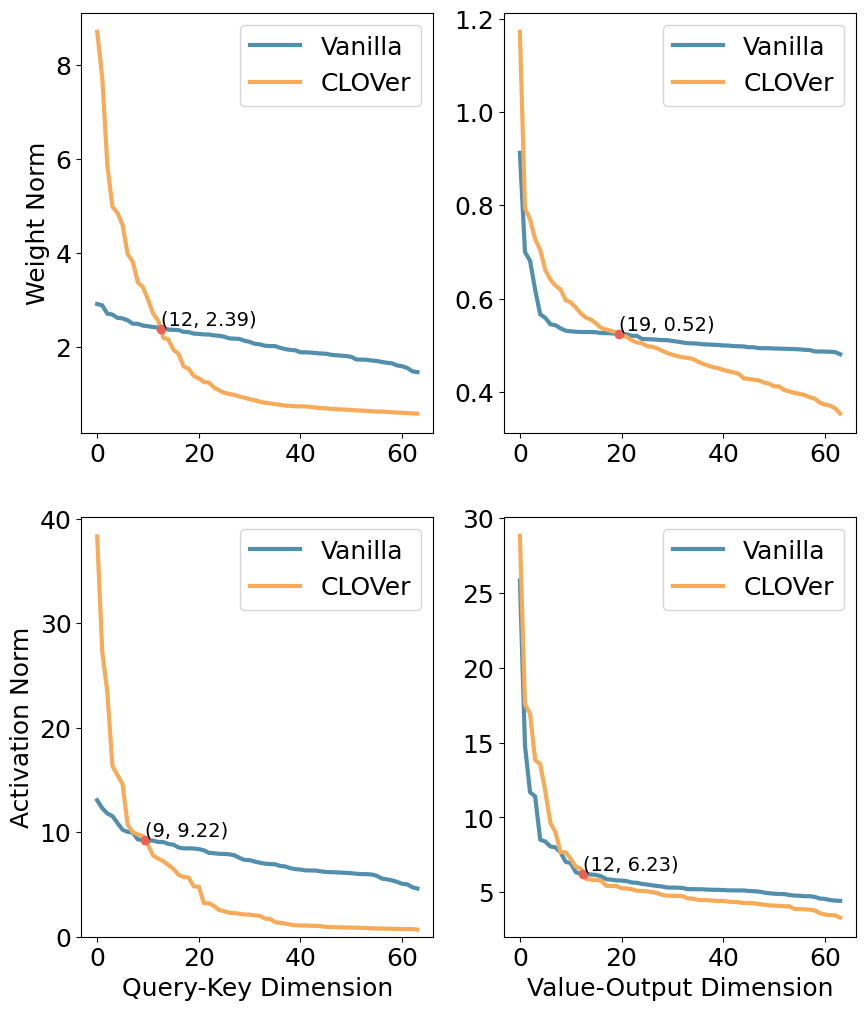

In [11]:
import matplotlib.pyplot as plt
colors=["#E76254","#EF8A47", "#F7AA58","#FFD06F", "#FFE6B7","#AADCE0","#72BCD5", "#528FAD","#376795", "#1E466E", "#E76254","#B75347",'#94B594']
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(2,2,figsize=(10, 12))
axs[0,0].plot(q_weight, label="Vanilla", linewidth=3,color=colors[7])
axs[0,0].plot(orthogonal_q_weight, label="CLOVer", linewidth=3,color=colors[2])
idx = torch.where((orthogonal_q_weight-q_weight)<=0)[0].min().item()
intersection_x = idx-0.5
intersection_y = (orthogonal_q_weight[idx-1:idx+1]+q_weight[idx-1:idx+1]).mean().item()/2
axs[0,0].plot(intersection_x, intersection_y,'o', color=colors[0])
axs[0,0].text(intersection_x, intersection_y, f'({intersection_x-0.5:.0f}, {intersection_y:.2f})',fontsize=14, ha='left', va='bottom')
axs[0,0].legend()
axs[0,0].set_ylabel("Weight Norm")


axs[0,1].plot(v_weight, label="Vanilla", linewidth=3,color=colors[7])
axs[0,1].plot(orthogonal_v_weight, label="CLOVer", linewidth=3,color=colors[2])
idx = torch.where((orthogonal_v_weight-v_weight)<=0)[0].min().item()
intersection_x = idx-0.5
intersection_y = (orthogonal_v_weight[idx-1:idx+1]+v_weight[idx-1:idx+1]).mean().item()/2
axs[0,1].plot(intersection_x, intersection_y,'o', color=colors[0])
axs[0,1].text(intersection_x, intersection_y, f'({intersection_x-0.5:.0f}, {intersection_y:.2f})',fontsize=14, ha='left', va='bottom')
axs[0,1].legend()


axs[1,0].plot(qk_norm_list, label="Vanilla", linewidth=3,color=colors[7])
axs[1,0].plot(orthogonal_qk_norm_list, label="CLOVer", linewidth=3,color=colors[2])
idx = torch.where((orthogonal_qk_norm_list-qk_norm_list)<=0)[0].min().item()
intersection_x = idx-0.5
intersection_y = (orthogonal_qk_norm_list[idx-1:idx+1]+qk_norm_list[idx-1:idx+1]).mean().item()/2
axs[1,0].plot(intersection_x, intersection_y,'o', color=colors[0])
axs[1,0].text(intersection_x, intersection_y, f'({intersection_x-0.5:.0f}, {intersection_y:.2f})',fontsize=14, ha='left', va='bottom')
axs[1,0].set_ylim(0)
axs[1,0].legend()
axs[1,0].set_xlabel("Query-Key Dimension")
axs[1,0].set_ylabel("Activation Norm")

axs[1,1].plot(v_norm_list, label="Vanilla", linewidth=3,color=colors[7])
axs[1,1].plot(orthogonal_v_norm_list, label="CLOVer", linewidth=3,color=colors[2])
idx = torch.where((orthogonal_v_norm_list-v_norm_list)<=0)[0].min().item()
intersection_x = idx-0.5
intersection_y = (orthogonal_v_norm_list[idx-1:idx+1]+v_norm_list[idx-1:idx+1]).mean().item()/2
axs[1,1].plot(intersection_x, intersection_y,'o', color=colors[0])
axs[1,1].text(intersection_x, intersection_y, f'({intersection_x-0.5:.0f}, {intersection_y:.2f})',fontsize=14, ha='left', va='bottom')
axs[1,1].legend()
axs[1,1].set_xlabel("Value-Output Dimension")

plt.savefig("imgs/gpt2_norm.pdf", bbox_inches="tight")